In [3]:
!pip install tqdm==4.67.1 | tail -n 1
!pip install numpy==2.2.0 | tail -n 1
!pip install pandas==2.2.3 | tail -n 1
!pip install matplotlib==3.9.4 | tail -n 1
!pip install seaborn==0.13.2 | tail -n 1
!pip install scikit-learn==1.6.0 | tail -n 1

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [ ]:
def display_feature_importances(model, feature_names):
   
    feature_importance = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  
    plt.show()
    
    return feature_importance_df

In [ ]:
class TreeSplanerClassifier:
  
    def __init__(self, clf, feature_names=None, target_names=None):
        self.clf = clf
        
        if feature_names is None:
            self.feature_names = [f"feature_{i}" for i in range(clf.tree_.n_features)]
        else:
            self.feature_names = feature_names

        if target_names is None:
            self.target_names = [f"class_{i}" for i in range(clf.tree_.n_classes)]
        else:
            self.target_names = target_names
      
        self.children_left = clf.tree_.children_left
        self.children_right = clf.tree_.children_right
        self.feature = clf.tree_.feature
        self.threshold = clf.tree_.threshold
        self.value = clf.tree_.value
        
    def find_paths_from_root(self, node=0, path=None, all_paths=None):
       
        if path is None:
            path = []
        if all_paths is None:
            all_paths = []
        
        path.append(node)

        
        if self.children_left[node] == -1 and self.children_right[node] == -1:
            all_paths.append(list(path))
        else:
            
            if self.children_left[node] != -1:
                self.find_paths_from_root(self.children_left[node], path, all_paths)
            if self.children_right[node] != -1:
                self.find_paths_from_root(self.children_right[node], path, all_paths)
        
        path.pop()
        
        return all_paths

    def decision_tree_to_text(self):
      
        all_paths = self.find_paths_from_root()
        branch = "If "
        number_paths = len(all_paths)
   

        for p, path in enumerate(all_paths):
            branch += " ("
            for l, node in enumerate(path):
                            
            
                if node in self.children_right:
                    eq = ">"
                    
                
                elif node==0 and  path[l+1] in  self.children_right:
                    eq = ">"
                    
                else:
                    eq = "<="

                if l != len(path) - 1:
                    branch += f"{self.feature_names[self.feature[node]]} {eq} {round(self.threshold[node], 2)} and "
                else:
                    target_index=np.argmax(self.value[node, 0, :])

                    predicted_class = self.target_names[target_index]
                    probability_class=round(self.clf.tree_.value[node,0,target_index],3)
                    branch += f"{self.feature_names[self.feature[node]]} {eq} {round(self.threshold[node], 2)} then class is {predicted_class}  with probability of {probability_class}"
            branch += " )" + (" or" if p != number_paths - 1 else "")
        return branch

    def build_text_prediction(self, samples):
        """
        Generates natural language predictions for specific samples.
        """
        branches = []

        for sample in samples:
            sample = np.array(sample).reshape(1, -1)
            node_indicator = self.clf.decision_path(sample)
            predicted_index=int(self.clf.predict(sample)[0])
            predicted_class = self.target_names[predicted_index]

            probability_class=np.round(self.clf.predict_proba(sample)[0][predicted_index],3)
                       
            branch = ""

            # Get the path for the current sample
            path = node_indicator.indices
            for n, node in enumerate(path):
                # Determine inequality direction based on child position
                if node in self.children_right:
                    eq = ">"
                else:
                    eq = "<="
                    
                if n != len(path) - 1:
                    branch += f"{self.feature_names[self.feature[node]]} {eq} {round(self.threshold[node], 2)} and "
                else:
                    branch += f"{self.feature_names[self.feature[node]]} {eq} {round(self.threshold[node], 2)} therefore the class is {predicted_class} with probability of {probability_class}"

            branches.append(branch)

        return branches

    def branch_impurity(self):
        all_paths=self.find_paths_from_root()
        node_impurity=self.clf.tree_.impurity
        feature=self.feature
        branch_impurity=""
        for p, path in enumerate(all_paths):
            branch_impurity+=f" For branch {p+1} "
            
            for node in path:
        
                branch_impurity+=f" for split  {node } and feature {self.feature_names[feature[node]]} impurity is {round(node_impurity[node],3)} "
        return branch_impurity

In [11]:
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6exL12iQvqfWQgXniFXM4g/Predict%20Student%20Dropout%20and%20Academic%20Success.csv", delimiter=";")
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [12]:
print("\nShape of the dataset (rows, columns):", df.shape)


Shape of the dataset (rows, columns): (4424, 37)


In [13]:
print("\nColumns in the dataset:", df.columns)


Columns in the dataset: Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
   

In [14]:
df['Target'].value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

<Axes: xlabel='Target', ylabel='count'>

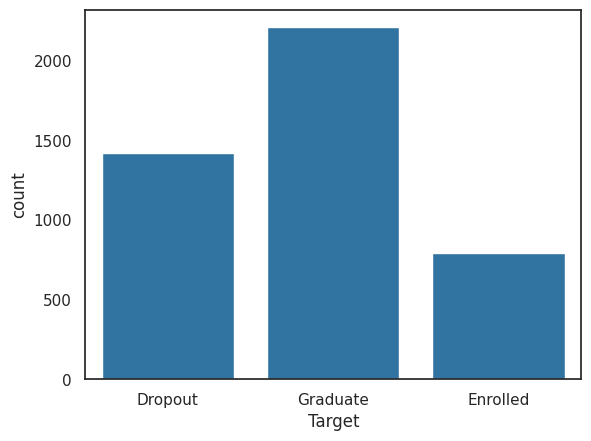

In [15]:
sns.countplot(x='Target', data=df)

In [16]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [17]:
df.nunique()

Marital status                                      6
Application mode                                   18
Application order                                   8
Course                                             17
Daytime/evening attendance\t                        2
Previous qualification                             17
Previous qualification (grade)                    101
Nacionality                                        21
Mother's qualification                             29
Father's qualification                             34
Mother's occupation                                32
Father's occupation                                46
Admission grade                                   620
Displaced                                           2
Educational special needs                           2
Debtor                                              2
Tuition fees up to date                             2
Gender                                              2
Scholarship holder          

In [18]:
# Function to map categories to numbers
def map_categories(row, feature, mapping):
    return mapping.get(row[feature], -1)  # Default to -1 if the value is not in the mapping


# Reduce Marital Status categories
marital_status_mapping = {
    1: 1,  # Single
    2: 2,  # Married/Union
    3: 3,  # Separated/Other
    4: 3,  # Separated/Other
    5: 2,  # Married/Union
    6: 3   # Separated/Other
}

df['Marital status'] = df.apply(lambda row: map_categories(row, 'Marital status', marital_status_mapping), axis=1)

In [19]:
data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/xmqtgnRT0GpQnTsjJHDVTw/mapped-dropout-data.csv')
data.head()

,Unnamed: 0,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,5,2,1,2,122.0,1,1,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,1,4,1,3,1,2,160.0,1,2,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,2,1,1,5,2,1,2,122.0,1,1,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,3,1,1,2,2,1,2,122.0,1,1,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,4,2,5,1,3,0,2,100.0,1,1,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [20]:
data = data.drop('Unnamed: 0', axis = 1)
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,1,5,2,1,2,122.0,1,1,1,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,4,1,3,1,2,160.0,1,2,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,2,1,2,122.0,1,1,1,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,1,2,2,1,2,122.0,1,1,1,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,5,1,3,0,2,100.0,1,1,1,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [21]:
# Get all the categorical columns and exlude the numeric ones
cat_columns = data.columns.to_list()

# List of numerical columns
num_columns = ['Previous qualification (grade)', 'Admission grade', 
               'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']

# Remove the numerical columns from cat_columns
for col in num_columns:
    cat_columns.remove(col)
    
cat_columns

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance\t',
 'Previous qualification',
 'Nacionality',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 "Father's occupation",
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'International',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rate',
 'GDP',
 'Target']

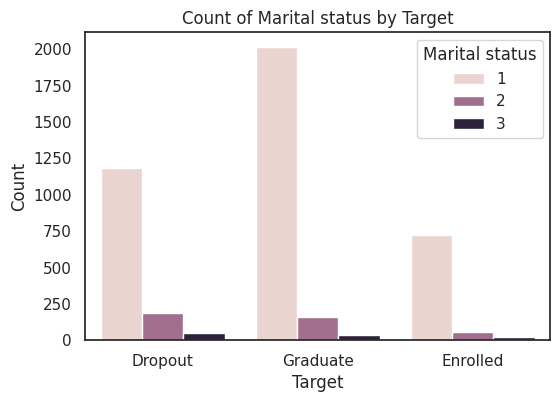

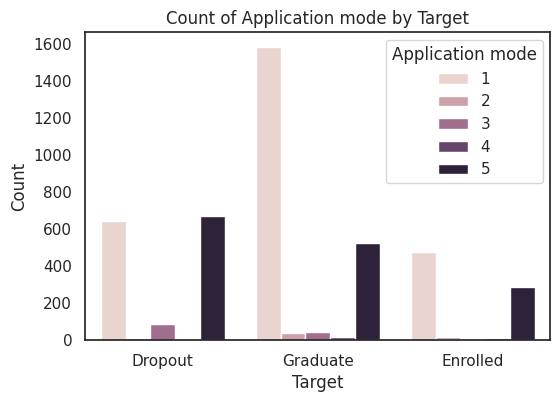

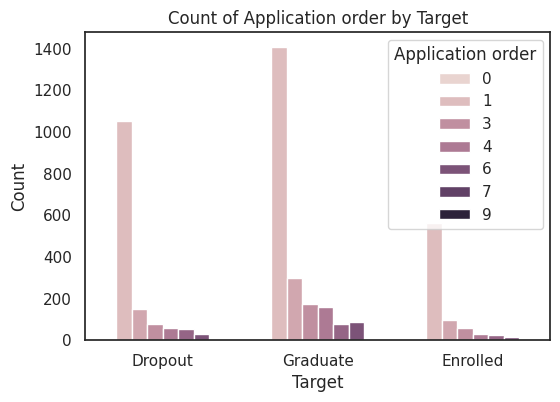

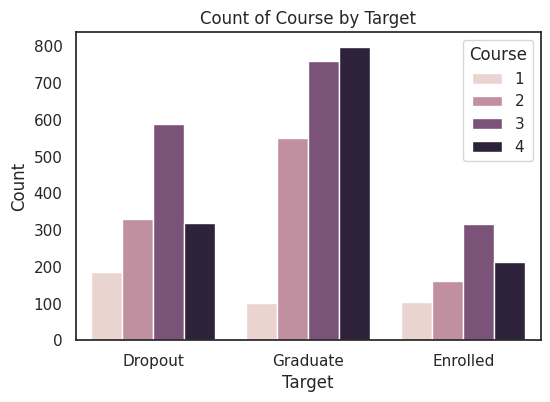

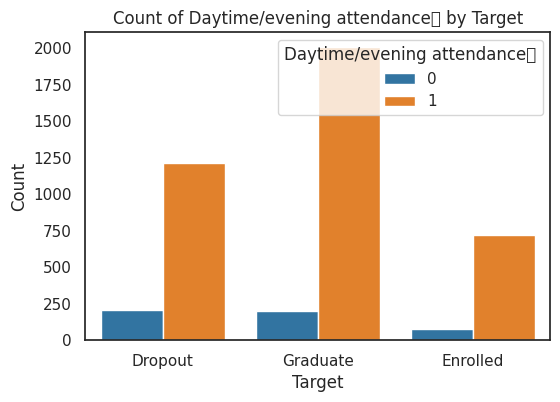

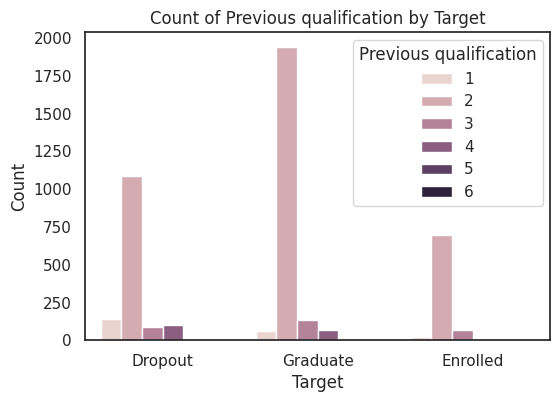

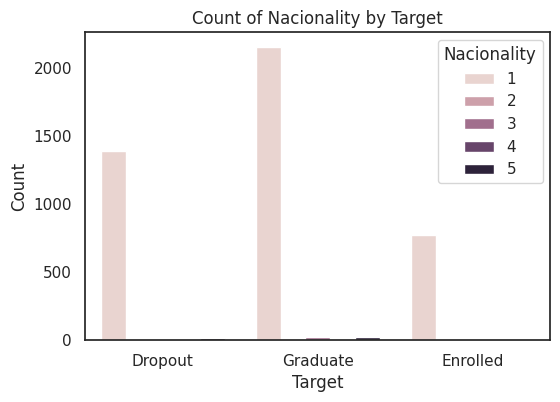

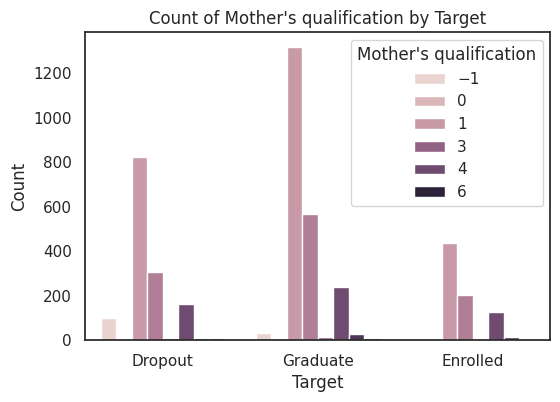

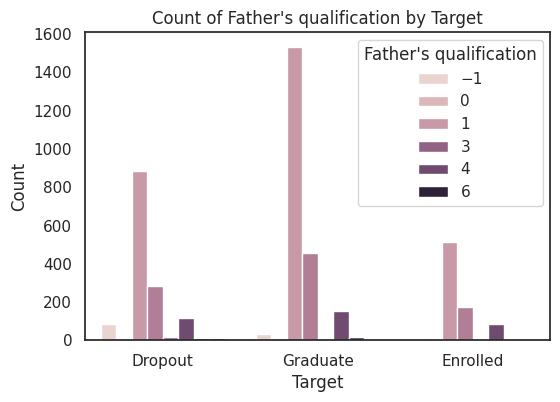

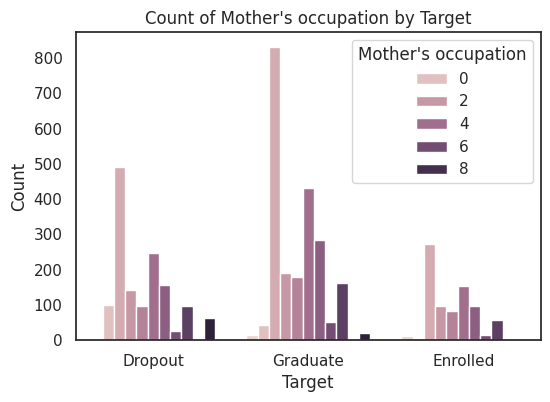

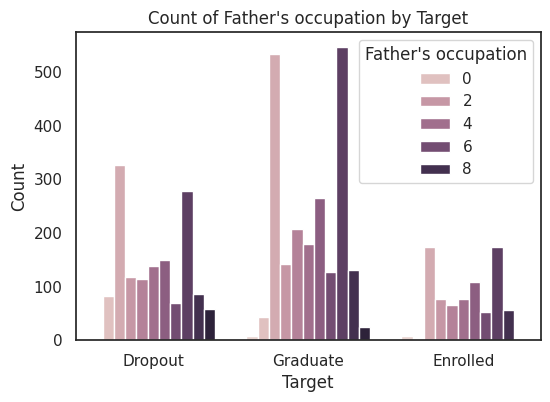

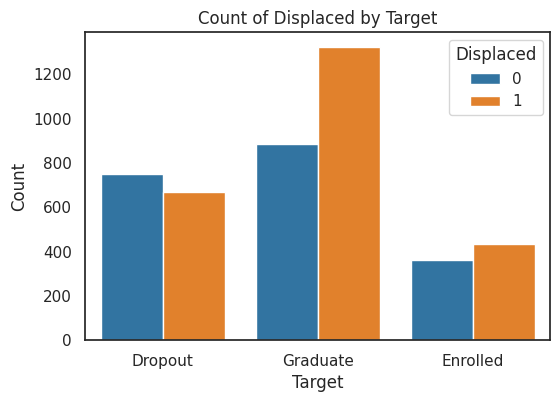

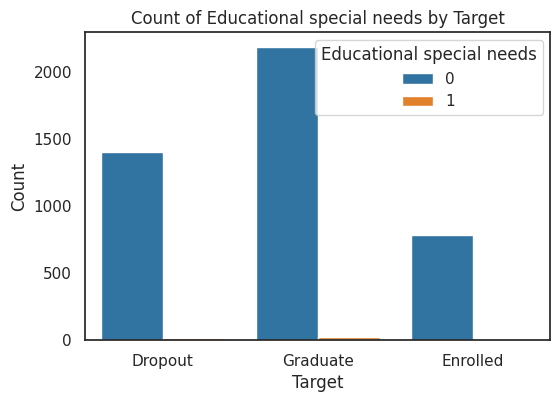

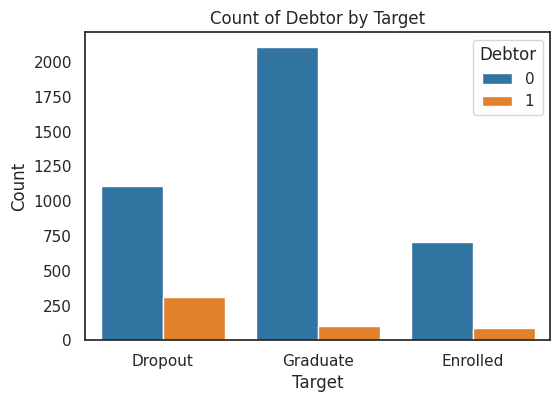

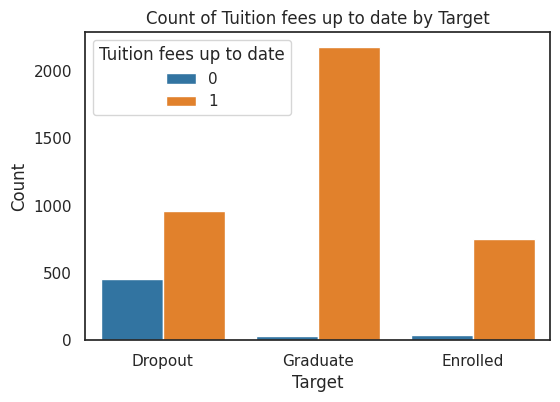

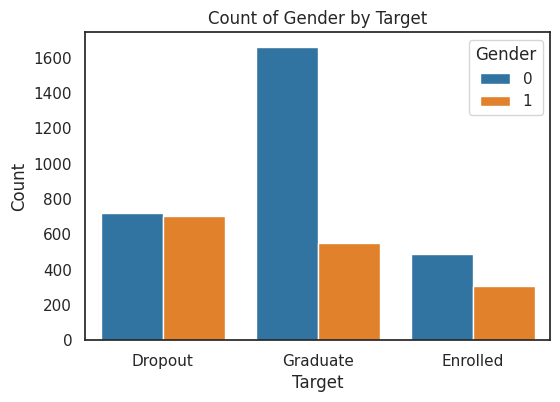

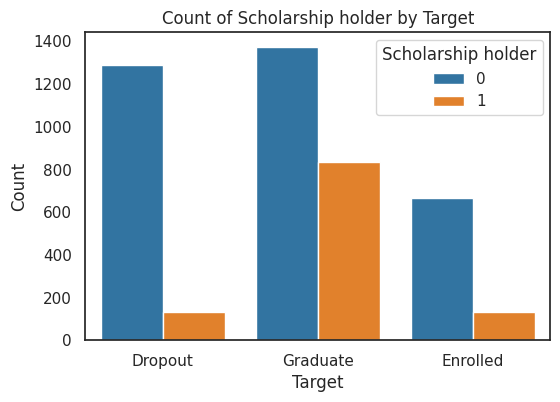

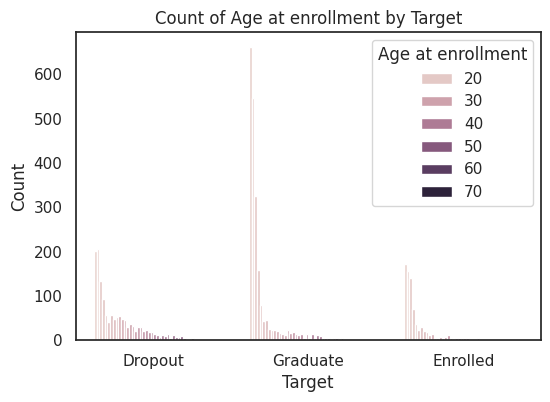

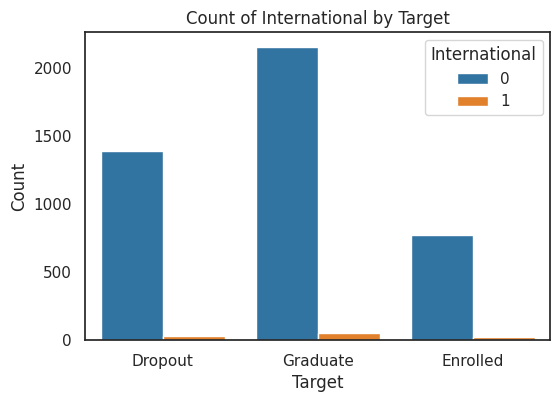

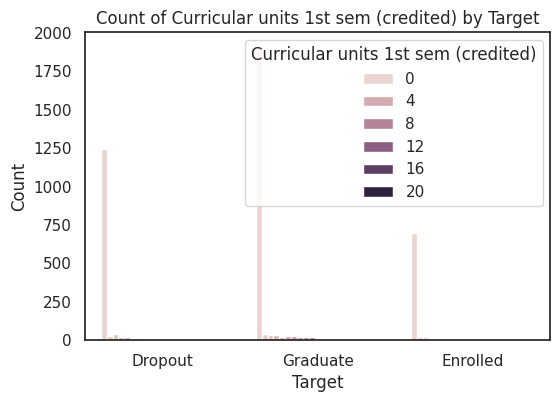

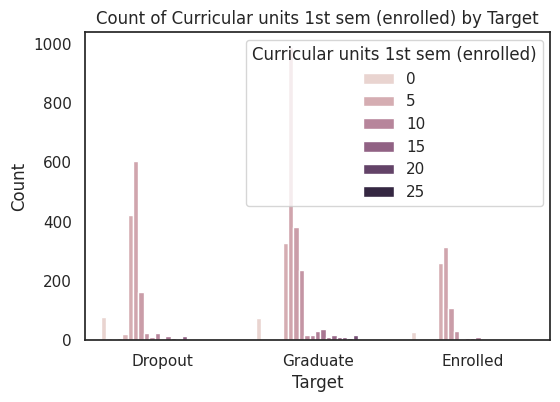

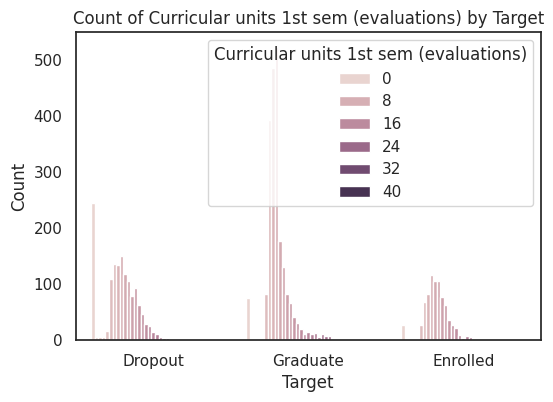

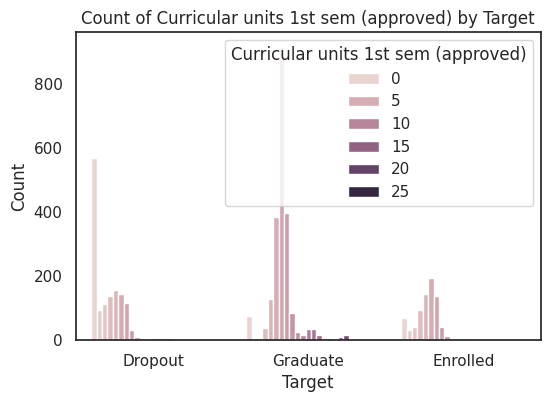

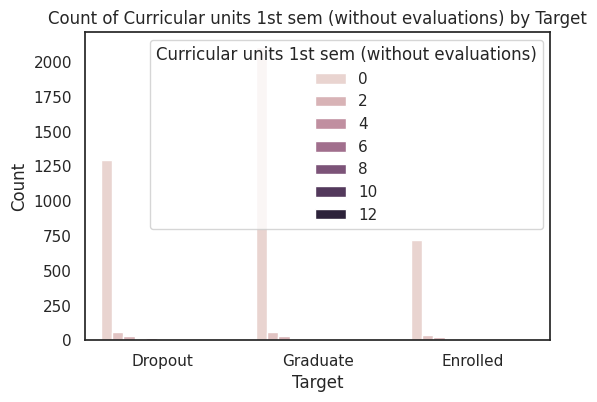

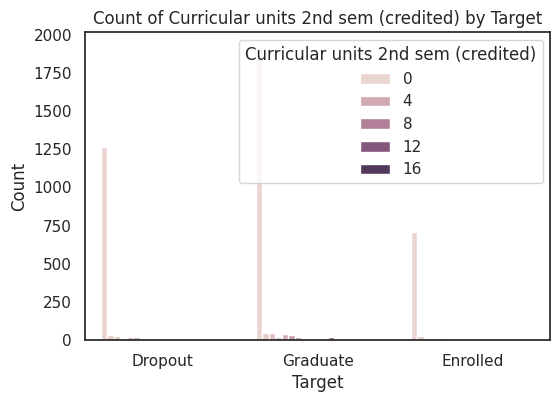

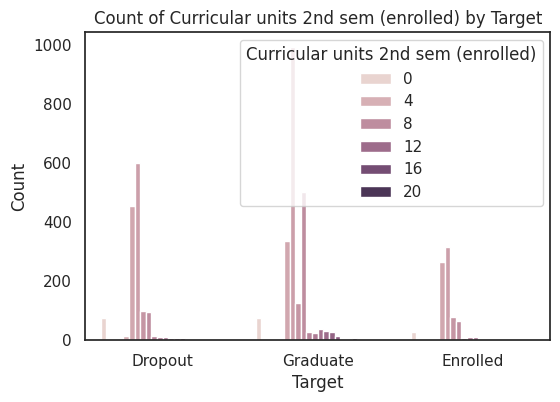

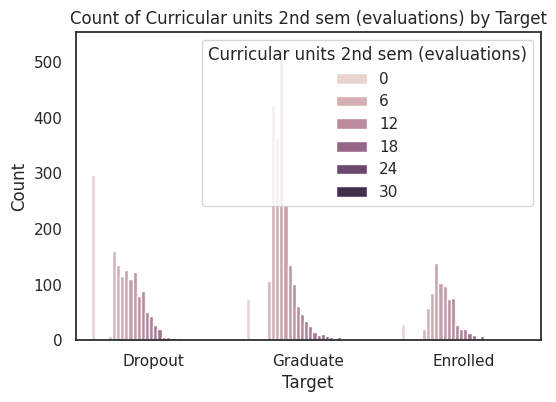

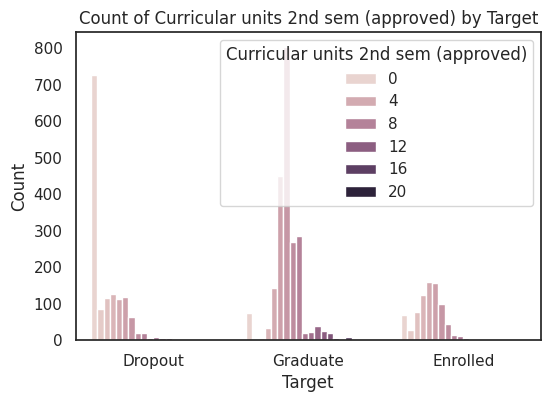

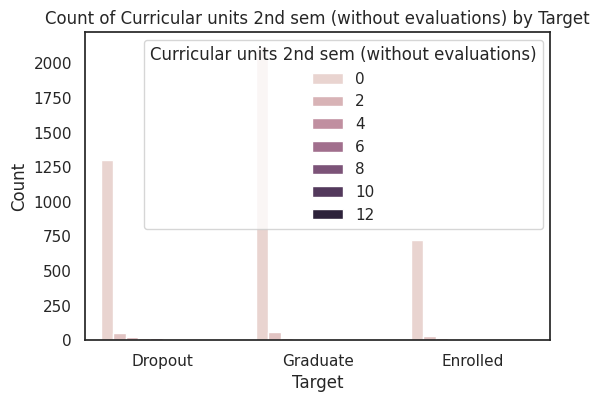

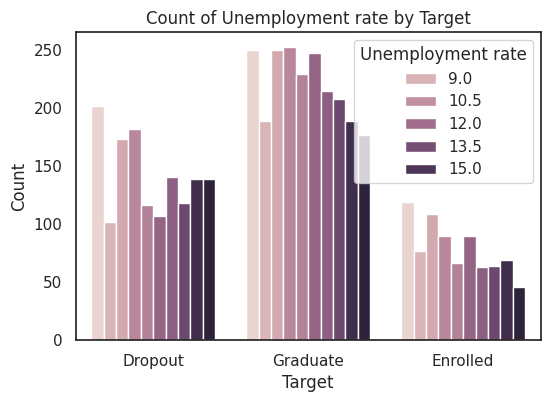

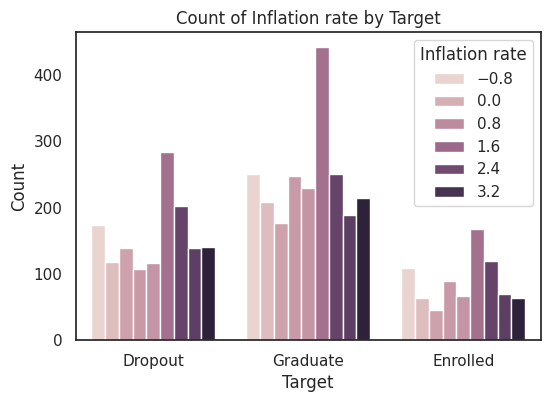

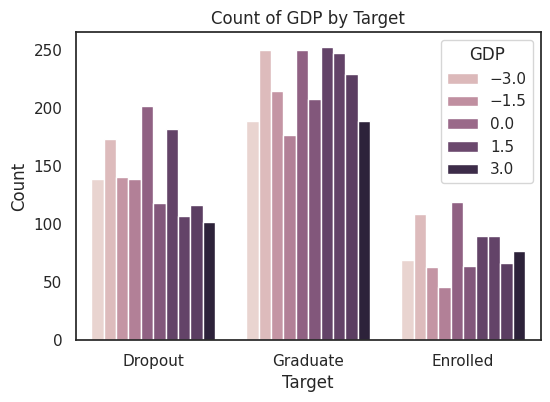

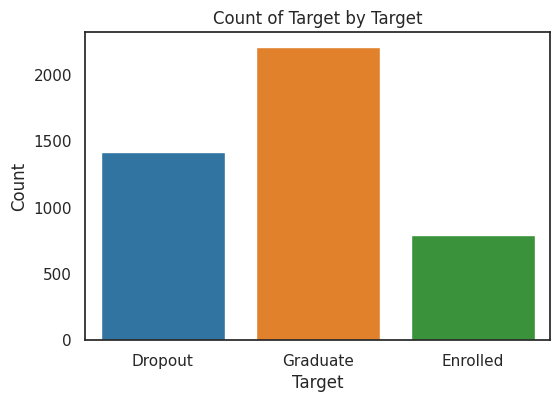

In [23]:
for column in cat_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Target', hue=column, data=data)
    plt.title(f'Count of {column} by Target')
    plt.ylabel('Count')
    plt.xlabel('Target')
    plt.xticks(rotation=0)
    plt.show()

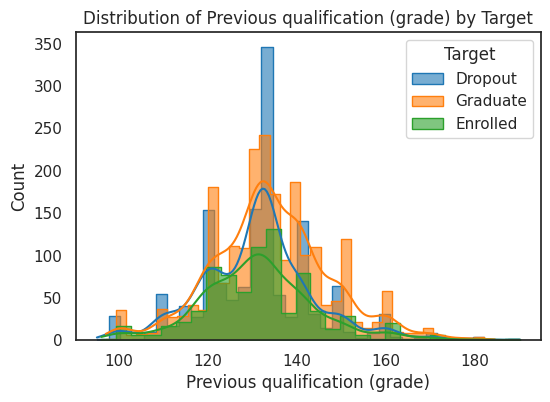

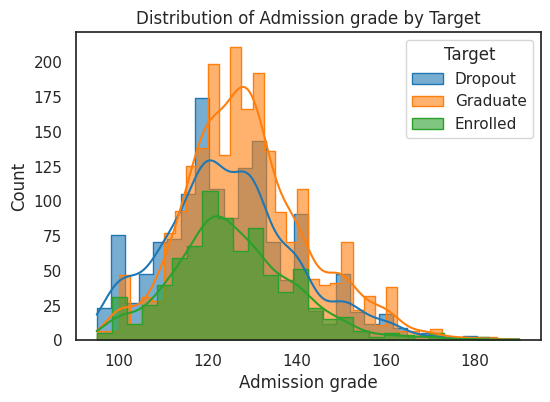

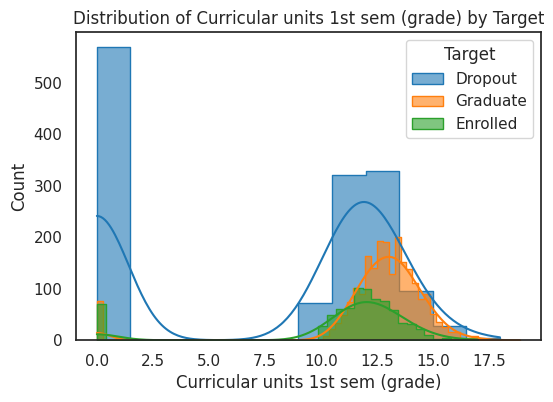

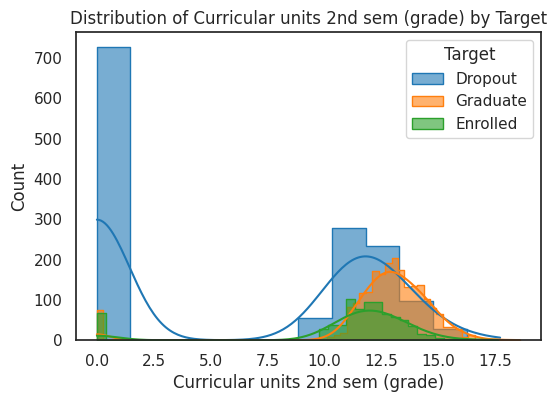

In [25]:
for column in num_columns:
    plt.figure(figsize=(6, 4))
    for target in data['Target'].unique():
        subset = data[data['Target'] == target]
        sns.histplot(subset[column], kde=True, label=target, element="step", alpha=0.6)
    plt.title(f'Distribution of {column} by Target')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='Target')
    plt.show()

In [26]:
y = data['Target']
y.head()

0     Dropout
1    Graduate
2     Dropout
3    Graduate
4    Graduate
Name: Target, dtype: object

In [27]:
X = data.drop('Target',axis=1)
X.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,1,5,2,1,2,122.0,1,1,1,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,4,1,3,1,2,160.0,1,2,4,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,2,1,2,122.0,1,1,1,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,1,2,2,1,2,122.0,1,1,1,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,5,1,3,0,2,100.0,1,1,1,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
def decisonTreeClassifier(X_train, y_train, X_test, y_test):
    clf = DecisionTreeClassifier(random_state=42)
    
    # Train the model on the training set
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    return y_pred, clf

In [30]:
y_pred, clf = decisonTreeClassifier(X_train, y_train, X_test, y_test)

In [31]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix: \n{conf_matrix}\n")
print(f"Classification Report: \n{class_report}")

Accuracy: 0.6937853107344633

Confusion Matrix: 
[[202  52  30]
 [ 44  76  31]
 [ 52  62 336]]

Classification Report: 
              precision    recall  f1-score   support

     Dropout       0.68      0.71      0.69       284
    Enrolled       0.40      0.50      0.45       151
    Graduate       0.85      0.75      0.79       450

    accuracy                           0.69       885
   macro avg       0.64      0.65      0.64       885
weighted avg       0.72      0.69      0.70       885



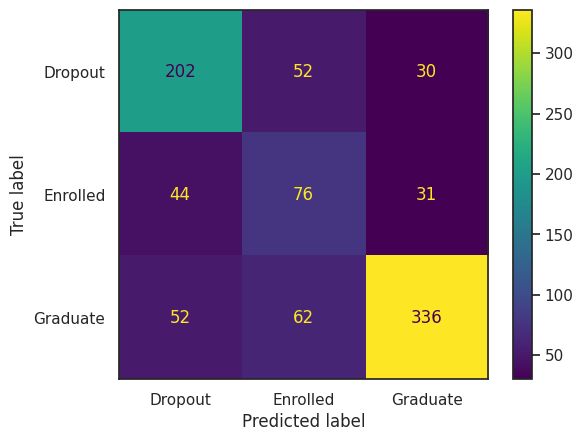

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=clf.classes_)
disp.plot()
plt.show()

In [33]:
print("Feature name ", X_train.columns, "\n")

Feature name  Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curric

In [34]:
print("Feature importance ", clf.feature_importances_)

Feature importance  [0.00363192 0.00529164 0.02261425 0.01461459 0.00192666 0.00368896
 0.0405238  0.0032141  0.01300267 0.01194011 0.02685379 0.03009934
 0.043878   0.00259629 0.00283908 0.01115717 0.04272267 0.00672653
 0.00736787 0.0436112  0.00186018 0.00461631 0.03582721 0.03503435
 0.02468336 0.05046486 0.00572307 0.00779882 0.01168466 0.02882911
 0.34319118 0.04325562 0.00528854 0.02041513 0.01700742 0.02601956]


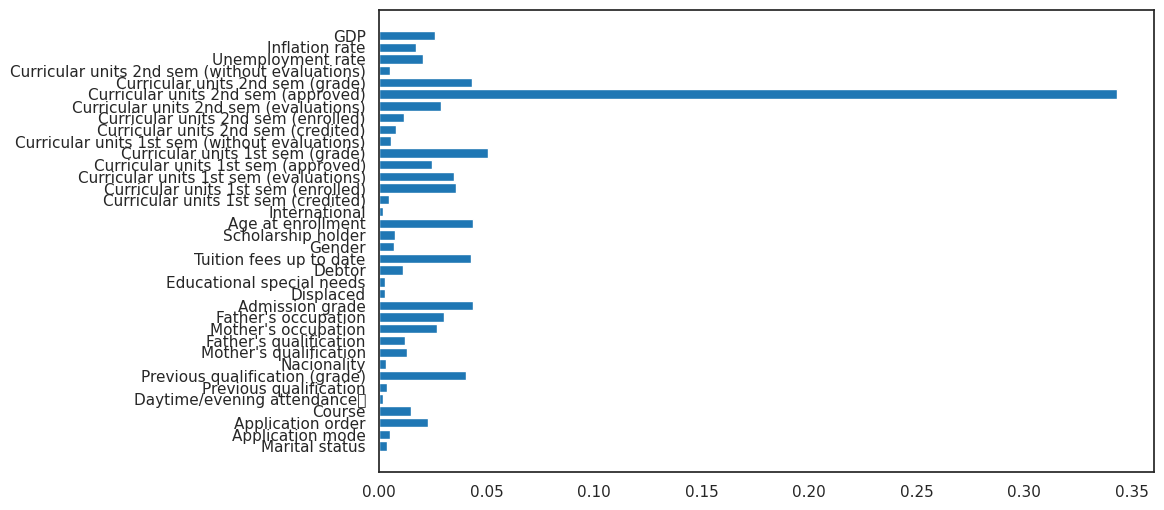

In [35]:
feature_importance_trees = display_feature_importances(clf, X_train.columns)

In [36]:
def randomForestClassifier(X_train, y_train, X_test, y_test):
    random_forest_model = RandomForestClassifier(random_state=42,n_estimators=100)
    
    # Train the model on the training set
    random_forest_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = random_forest_model.predict(X_test)

    return y_pred, random_forest_model

In [37]:
y_pred, random_forest_model = randomForestClassifier(X_train, y_train, X_test, y_test)

In [38]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix: \n{conf_matrix}\n")
print(f"Classification Report: \n{class_report}")

Accuracy: 0.8

Confusion Matrix: 
[[218  34  32]
 [ 37  67  47]
 [ 14  13 423]]

Classification Report: 
              precision    recall  f1-score   support

     Dropout       0.81      0.77      0.79       284
    Enrolled       0.59      0.44      0.51       151
    Graduate       0.84      0.94      0.89       450

    accuracy                           0.80       885
   macro avg       0.75      0.72      0.73       885
weighted avg       0.79      0.80      0.79       885



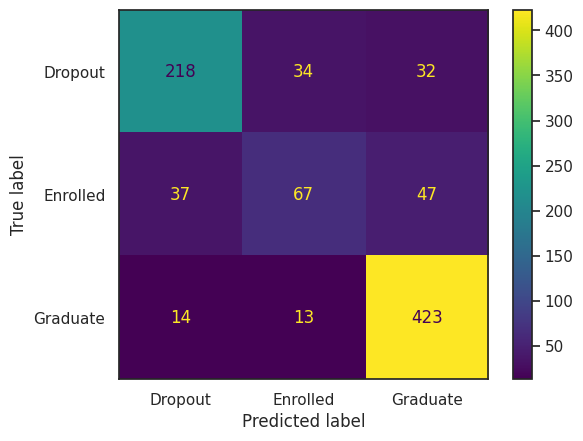

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=random_forest_model.classes_)
disp.plot()
plt.show()

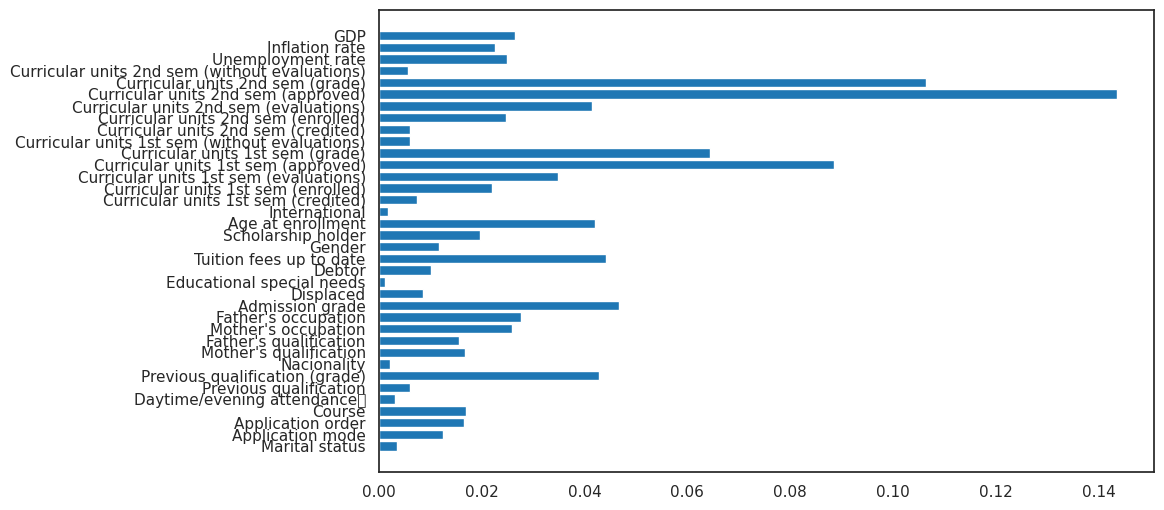

In [40]:
feature_importance_rf = display_feature_importances(random_forest_model, X_train.columns)

In [41]:
data = data.drop('Curricular units 2nd sem (approved)', axis=1)
data.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd se

In [42]:
# After dropping the column we begin the model training
y = data['Target']
y.head()

X = data.drop('Target',axis=1)
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [44]:
y_pred, clf = decisonTreeClassifier(X_train, y_train, X_test, y_test)

In [46]:
 # Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix: \n{conf_matrix}\n")
print(f"Classification Report: \n{class_report}")

Accuracy: 0.6384180790960452

Confusion Matrix: 
[[190  63  31]
 [ 45  60  46]
 [ 58  77 315]]

Classification Report: 
              precision    recall  f1-score   support

     Dropout       0.65      0.67      0.66       284
    Enrolled       0.30      0.40      0.34       151
    Graduate       0.80      0.70      0.75       450

    accuracy                           0.64       885
   macro avg       0.58      0.59      0.58       885
weighted avg       0.67      0.64      0.65       885



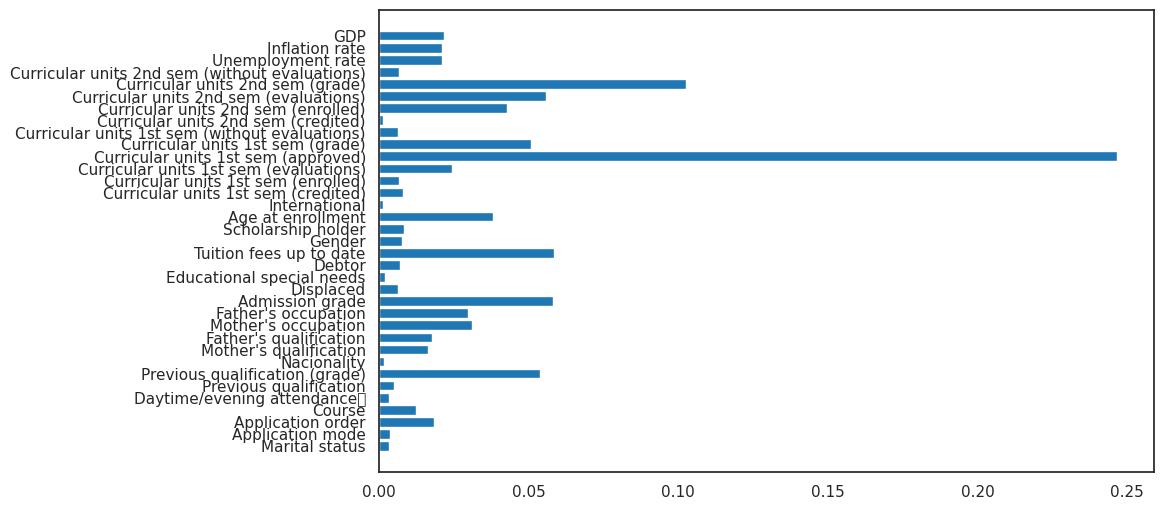

In [47]:
feature_importance_trees = display_feature_importances(clf, X_train.columns)

In [ ]:
data = data.drop(['Curricular units 1st sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 1st sem (grade)', 'Tuition fees up to date', 'Curricular units 2nd sem (evaluations)', 'Curricular units 1st sem (enrolled)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (without evaluations)'], axis=1)

In [54]:
# After dropping the column we begin the model training
y = data['Target']
y.head()

X = data.drop('Target',axis=1)
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
y_pred, clf = decisonTreeClassifier(X_train, y_train, X_test, y_test)

In [56]:
 # Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix: \n{conf_matrix}\n")
print(f"Classification Report: \n{class_report}")

Accuracy: 0.503954802259887

Confusion Matrix: 
[[141  42 101]
 [ 42  39  70]
 [ 92  92 266]]

Classification Report: 
              precision    recall  f1-score   support

     Dropout       0.51      0.50      0.50       284
    Enrolled       0.23      0.26      0.24       151
    Graduate       0.61      0.59      0.60       450

    accuracy                           0.50       885
   macro avg       0.45      0.45      0.45       885
weighted avg       0.51      0.50      0.51       885



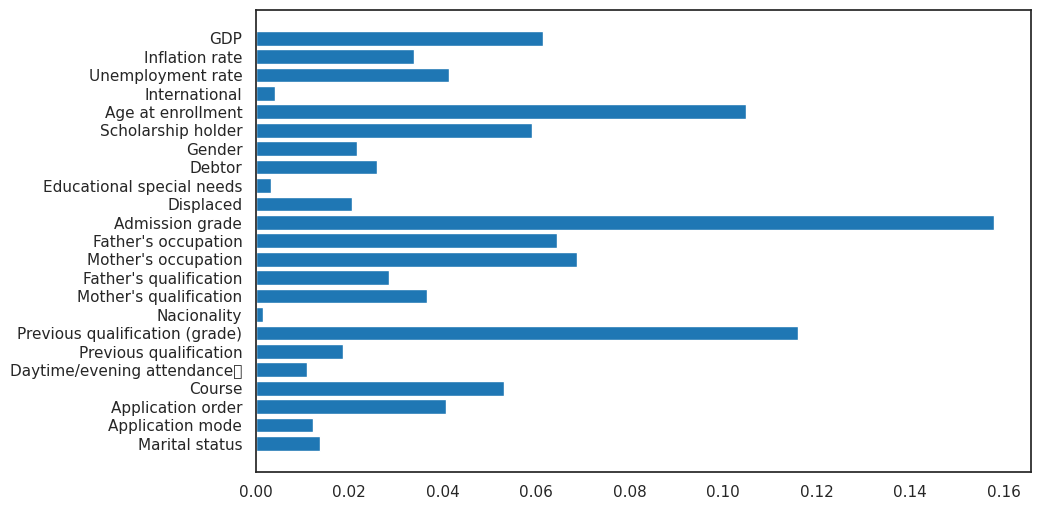

In [57]:
feature_importance_trees = display_feature_importances(clf, X_train.columns)

In [58]:
y_pred, random_forest_model = randomForestClassifier(X_train, y_train, X_test, y_test)

In [59]:
 # Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix: \n{conf_matrix}\n")
print(f"Classification Report: \n{class_report}")

Accuracy: 0.6203389830508474

Confusion Matrix: 
[[172  16  96]
 [ 49  19  83]
 [ 73  19 358]]

Classification Report: 
              precision    recall  f1-score   support

     Dropout       0.59      0.61      0.60       284
    Enrolled       0.35      0.13      0.19       151
    Graduate       0.67      0.80      0.73       450

    accuracy                           0.62       885
   macro avg       0.53      0.51      0.50       885
weighted avg       0.59      0.62      0.59       885



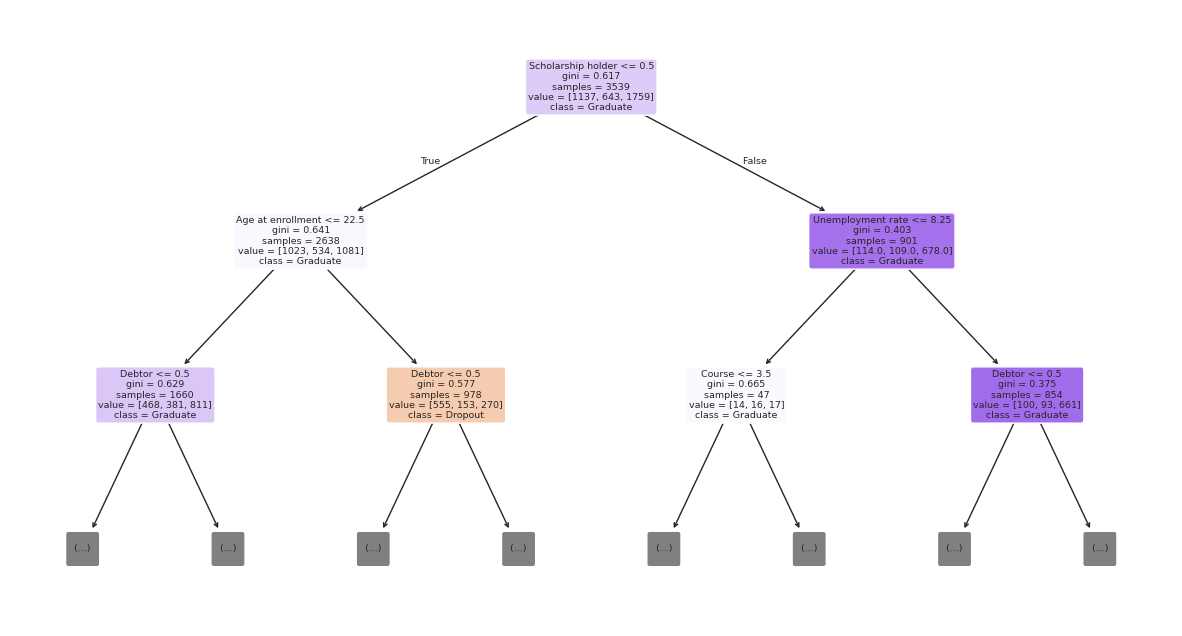

In [62]:
plt.figure(figsize=(15,8))  # Adjust the size for better readability
plot_tree(clf, feature_names=X_test.columns, class_names=clf.classes_,max_depth=2, filled=True, rounded=True)
plt.show()

In [63]:
tree_rules = export_text(clf, feature_names=list(X_train.columns),max_depth=2)
print(tree_rules)

|--- Scholarship holder <= 0.50
|   |--- Age at enrollment <= 22.50
|   |   |--- Debtor <= 0.50
|   |   |   |--- truncated branch of depth 22
|   |   |--- Debtor >  0.50
|   |   |   |--- truncated branch of depth 14
|   |--- Age at enrollment >  22.50
|   |   |--- Debtor <= 0.50
|   |   |   |--- truncated branch of depth 21
|   |   |--- Debtor >  0.50
|   |   |   |--- truncated branch of depth 16
|--- Scholarship holder >  0.50
|   |--- Unemployment rate <= 8.25
|   |   |--- Course <= 3.50
|   |   |   |--- truncated branch of depth 6
|   |   |--- Course >  3.50
|   |   |   |--- truncated branch of depth 4
|   |--- Unemployment rate >  8.25
|   |   |--- Debtor <= 0.50
|   |   |   |--- truncated branch of depth 19
|   |   |--- Debtor >  0.50
|   |   |   |--- truncated branch of depth 9



In [2]:
# Separate features and target
X = data.drop('Target', axis=1)
y = data['Target']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

NameError: name 'data' is not defined

In [65]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=0)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [1]:
# Initialize the TreeSplanerClassifier
tree_explainer = TreeSplanerClassifier(
    clf, 
    feature_names=X.columns.tolist(), 
    target_names=['Dropout', 'Enrolled', 'Graduate']
)

# Extract decision tree rules in text format
decision_rules = tree_explainer.decision_tree_to_text()
decision_rules[:1000]

NameError: name 'TreeSplanerClassifier' is not defined

In [ ]:
# Generate predictions for some test samples and explain in text format
test_sample_predictions = tree_explainer.build_text_prediction(X_test[:1].values)
test_sample_predictions

In [ ]:
# Extract branch impurity information
branch_impurities = tree_explainer.branch_impurity()
branch_impurities[:500]

In [ ]:
plt.figure(figsize=(20, 10))  # Adjust figure size for better readability
plot_tree(
    clf, 
    feature_names=X.columns.tolist(),  # Feature names for nodes
    class_names=['Dropout', 'Enrolled', 'Graduate'],  # Target class names
    filled=True,  # Color nodes based on class or feature importance
    rounded=True  # Round node boxes for aesthetics
)
plt.title("Decision Tree Visualization")
plt.show()

In [ ]:
# Extract all paths from the TreeSplanerClassifier
all_paths = tree_explainer.find_paths_from_root()

# Prepare data for tabular visualization
rules_data = []
for path in all_paths:
    conditions = []
    for node in path[:-1]:  # Exclude the leaf node
        if node in tree_explainer.children_right:
            eq = ">"
        else:
            eq = "<="
        condition = f"{tree_explainer.feature_names[tree_explainer.feature[node]]} {eq} {round(tree_explainer.threshold[node], 2)}"
        conditions.append(condition)
    
    # Extract class and probability at the leaf node
    leaf_node = path[-1]
    predicted_class = tree_explainer.target_names[np.argmax(tree_explainer.value[leaf_node][0])]
    probability = round(np.max(tree_explainer.value[leaf_node][0]) / np.sum(tree_explainer.value[leaf_node][0]), 3)
    
    # Append to rules_data
    rules_data.append({
        "Rule": " AND ".join(conditions),
        "Predicted Class": predicted_class,
        "Probability": probability
    })

# Convert to DataFrame
rules_df = pd.DataFrame(rules_data)
rules_df.head(10)

In [ ]:
rules_df['Rule'].iloc[0]

In [ ]:
# Summarize key rules
def summarize_rules(clf, feature_names):
    rules = export_text(clf, feature_names=feature_names)
    print("Decision Tree Rules Summary:")
    print(rules[:2000])  # Print the first 2000 characters for brevity
    return rules
